In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score

from matplotlib import pyplot as plt
import seaborn as sns 

from xgboost import XGBClassifier

import logging
log = logging.getLogger('logs/link_prediction_xgboost.log')

In [3]:
# dataset_index = 0
# network_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_network_features.csv', index_col=0)
# network_features_df = network_features_df.sample(frac=1).reset_index(drop=True)
# demographic_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_demographic_features.csv', index_col=0)
# demographic_features_df = demographic_features_df.sample(frac=1).reset_index(drop=True)
# genre_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_genre_features.csv', index_col=0)
# genre_features_df = genre_features_df.sample(frac=1).reset_index(drop=True)
# listening_profile_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_listening_profile_features.csv', index_col=0)
# listening_profile_features_df = listening_profile_features_df.sample(frac=1).reset_index(drop=True)
# listening_characteristics_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_listening_characteristics_features.csv', index_col=0)
# listening_characteristics_features_df = listening_characteristics_features_df.sample(frac=1).reset_index(drop=True)
# full_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_full.csv', index_col=0)
# full_df = full_df.sample(frac=1).reset_index(drop=True)
# feature_importances = {}
# accuracies = {}
# feature_dict = {
#     'df':demographic_features_df,
#     'gf':genre_features_df,
#     'lpf':listening_profile_features_df,
#     'lcf':listening_characteristics_features_df,
#     'nf':network_features_df
# }
# feature_combinations = {}
# for df in [None, 'df']:
#     for gf in [None, 'gf']:
#         for lpf in [None, 'lpf']:
#             for lcf in [None, 'lcf']:
#                 feature_combinations[(df, gf, lpf, lcf)] = {}
#                 dfs_to_combine = []
#                 for x in (df, gf, lpf, lcf):
#                     if x is not None:
#                         dfs_to_combine.append(feature_dict[x])
#                 if len(dfs_to_combine) > 0:
#                     feature_combinations[(df, gf, lpf, lcf)]['dataframe_'+str(dataset_index)] = pd.concat(dfs_to_combine, axis=1)
#                     feature_combinations[(df, gf, lpf, lcf)]['dataframe_'+str(dataset_index)] = feature_combinations[(df, gf, lpf, lcf)]['dataframe'].loc[:,~feature_combinations[(df, gf, lpf, lcf)]['dataframe'].columns.duplicated()]

In [2]:
# 'user_groups_freebase_weighted_average_diversity', 'user_groups_mainstreaminess_global', 'user_groups_novelty_artist_avg_6months'
dataset_id = 0
listening_characteristics_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_id) + '/links_df_listening_characteristics_features.csv', index_col=0)
listening_characteristics_features_df = listening_characteristics_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
listening_characteristics_features_df = listening_characteristics_features_df[[
    'user1_freebase_weighted_average_diversity',
    'user2_freebase_weighted_average_diversity',
    'relative_change_freebase_weighted_average_diversity',
    'user1_user_groups_freebase_weighted_average_diversity_high',
    'user1_user_groups_freebase_weighted_average_diversity_low',
    'user1_user_groups_freebase_weighted_average_diversity_medium',
    'user2_user_groups_freebase_weighted_average_diversity_high',
    'user2_user_groups_freebase_weighted_average_diversity_low',
    'user2_user_groups_freebase_weighted_average_diversity_medium',
    'same_user_groups_freebase_weighted_average_diversity',
    'user1_mainstreaminess_global',
    'user2_mainstreaminess_global',
    'relative_change_mainstreaminess_global',
    'user1_user_groups_mainstreaminess_global_high',
    'user1_user_groups_mainstreaminess_global_low',
    'user1_user_groups_mainstreaminess_global_medium',
    'user2_user_groups_mainstreaminess_global_high',
    'user2_user_groups_mainstreaminess_global_low',
    'user2_user_groups_mainstreaminess_global_medium',
    'same_user_groups_mainstreaminess_global',
    'user1_novelty_artist_avg_6months',
    'user2_novelty_artist_avg_6months',
    'relative_change_novelty_artist_avg_6months',
    'user1_user_groups_novelty_artist_avg_6months_high',
    'user1_user_groups_novelty_artist_avg_6months_low',
    'user1_user_groups_novelty_artist_avg_6months_medium',
    'user2_user_groups_novelty_artist_avg_6months_high',
    'user2_user_groups_novelty_artist_avg_6months_low',
    'user2_user_groups_novelty_artist_avg_6months_medium',
    'same_user_groups_novelty_artist_avg_6months',
    'label'
]]
X_train, X_test, y_train, y_test = train_test_split(listening_characteristics_features_df.drop(columns=['label']), listening_characteristics_features_df['label'], test_size=0.2, random_state=0)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_proba_tmp = xgb.predict_proba(X_test)
y_pred_proba = []
for entry in y_pred_proba_tmp:
    y_pred_proba.append(entry[1])
predictions = [round(value) for value in y_pred]
# evaluate predictions
report = classification_report(y_test, predictions)
prfs_macro = precision_recall_fscore_support(y_test, predictions, average='macro')
prfs_micro = precision_recall_fscore_support(y_test, predictions, average='micro')
prfs_weighted = precision_recall_fscore_support(y_test, predictions, average='weighted')
print(prfs_weighted)
feature_importances = sorted(list(zip(xgb.feature_importances_, list(X_train.columns))),  key=lambda x: x[0], reverse=True)

[23:42:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7228755847081089, 0.7224965185466514, 0.7223489371573381, None)


In [4]:
average_precision_score(y_test, y_pred_proba)

0.8070515828100808

In [3]:
feature_importances

[(0.39396644, 'same_user_groups_freebase_weighted_average_diversity'),
 (0.06568945, 'user1_novelty_artist_avg_6months'),
 (0.05845456, 'user1_mainstreaminess_global'),
 (0.057491887, 'user1_freebase_weighted_average_diversity'),
 (0.047264636, 'user2_novelty_artist_avg_6months'),
 (0.044477414, 'user1_user_groups_freebase_weighted_average_diversity_medium'),
 (0.04440602, 'same_user_groups_novelty_artist_avg_6months'),
 (0.041110113, 'user2_mainstreaminess_global'),
 (0.040446315, 'user1_user_groups_mainstreaminess_global_medium'),
 (0.040399186, 'user2_freebase_weighted_average_diversity'),
 (0.033925865, 'user2_user_groups_freebase_weighted_average_diversity_medium'),
 (0.03240285, 'user1_user_groups_novelty_artist_avg_6months_medium'),
 (0.02242296, 'relative_change_mainstreaminess_global'),
 (0.021472245, 'relative_change_freebase_weighted_average_diversity'),
 (0.01630673, 'user2_user_groups_novelty_artist_avg_6months_medium'),
 (0.015262806, 'relative_change_novelty_artist_avg_6

In [ ]:
evaluation_results = []
for dataset_id in range(10):
    # Load datasets
#     network_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_network_features.csv', index_col=0)
#     network_features_df = network_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    demographic_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_demographic_features.csv', index_col=0)
    demographic_features_df = demographic_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    genre_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_genre_features.csv', index_col=0)
    genre_features_df = genre_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    listening_profile_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_listening_profile_features.csv', index_col=0)
    listening_profile_features_df = listening_profile_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    listening_characteristics_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_listening_characteristics_features.csv', index_col=0)
    listening_characteristics_features_df = listening_characteristics_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
#     full_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_full.csv', index_col=0)
#     full_df = full_df.sample(frac=1).reset_index(drop=True)
    # Map dataframes by attribute types
    feature_dict = {
        'df':demographic_features_df,
        'gf':genre_features_df,
        'lpf':listening_profile_features_df,
        'lcf':listening_characteristics_features_df,
        'nf':network_features_df
    }
    for split_seed in range(5):
        for df in [None, 'df']:
            for gf in [None, 'gf']:
                for lpf in [None, 'lpf']:
                    for lcf in [None, 'lcf']:
                        feature_combination = (df, gf, lpf, lcf)
                        print('Other features - dataset_id: ', dataset_id, ', split_seed: ', split_seed, ', feature_combination: ', feature_combination)
                        log.info('Other features - dataset_id: ', dataset_id, ', split_seed: ', split_seed, ', feature_combination: ', feature_combination)
                        if feature_combination == (None,None,None,None):
                            continue
                        dfs_to_combine = []
                        for x in (df, gf, lpf, lcf):
                            if x is not None:
                                dfs_to_combine.append(feature_dict[x])
                        input_df = pd.concat(dfs_to_combine, axis=1)
                        input_df = input_df.loc[:,~input_df.columns.duplicated()]
                                
                        X_train, X_test, y_train, y_test = train_test_split(input_df.drop(columns=['label']), input_df['label'], test_size=0.2, random_state=split_seed)
                        xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
                        user_ids_test = pd.DataFrame(X_test[['user1_user_id', 'user2_user_id']])
                        X_train = X_train.drop(columns=['user1_user_id', 'user2_user_id'])
                        X_test = X_test.drop(columns=['user1_user_id', 'user2_user_id'])
                        xgb.fit(X_train, y_train)
                        y_pred = xgb.predict(X_test)
                        predictions = [round(value) for value in y_pred]
                        # evaluate predictions
                        report = classification_report(y_test, predictions)
                        prfs_macro = precision_recall_fscore_support(y_test, predictions, average='macro')
                        prfs_micro = precision_recall_fscore_support(y_test, predictions, average='micro')
                        prfs_weighted = precision_recall_fscore_support(y_test, predictions, average='weighted')
                        print(prfs_weighted)
                        feature_importances = sorted(list(zip(xgb.feature_importances_, list(X_train.columns))),  key=lambda x: x[0], reverse=True)
                        evaluation_result = {
                            'dataset_id': dataset_id,
                            'split_seed': split_seed,
                            'demographic_features': False if df is None else True,
                            'listening_profile_features': False if lpf is None else True,
                            'genre_features': False if gf is None else True,
                            'listening_characteristics_features': False if lcf is None else True,
                            'report': report,
                            'xgb_feature_importances': feature_importances,
                            'user_ids_test': user_ids_test,
                            'y_test': y_test,
                            'y_pred': y_pred,
                            'prfs_macro': prfs_macro,
                            'prfs_micro': prfs_micro,
                            'prfs_weighted': prfs_weighted
                        }
                        evaluation_results.append(evaluation_result)

In [51]:
evaluation_results = []
for dataset_id in range(10):
    # Load datasets
    listening_profile_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_id) + '/links_df_listening_profile_features.csv', index_col=0)
    listening_profile_features_df = listening_profile_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    listening_characteristics_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_id) + '/links_df_listening_characteristics_features.csv', index_col=0)
    listening_characteristics_features_df = listening_characteristics_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    # Map dataframes by attribute types
    feature_dict = {
        'lpf':listening_profile_features_df,
        'lcf':listening_characteristics_features_df
    }
    for split_seed in range(5):
        for lpf in [None, 'lpf']:
            for lcf in [None, 'lcf']:
                feature_combination = (lpf, lcf)
                print('Other features - dataset_id: ', dataset_id, ', split_seed: ', split_seed, ', feature_combination: ', feature_combination)
                if feature_combination == (None,None):
                    continue
                dfs_to_combine = []
                for x in (lpf, lcf):
                    if x is not None:
                        dfs_to_combine.append(feature_dict[x])
                input_df = pd.concat(dfs_to_combine, axis=1)
                input_df = input_df.loc[:,~input_df.columns.duplicated()]
                                
                X_train, X_test, y_train, y_test = train_test_split(input_df.drop(columns=['label']), input_df['label'], test_size=0.2, random_state=split_seed)
                xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
                user_ids_test = pd.DataFrame(X_test[['user1_user_id', 'user2_user_id']])
                X_train = X_train.drop(columns=['user1_user_id', 'user2_user_id'])
                X_test = X_test.drop(columns=['user1_user_id', 'user2_user_id'])
                xgb.fit(X_train, y_train)
                y_pred = xgb.predict(X_test)
                predictions = [round(value) for value in y_pred]
                # evaluate predictions
                report = classification_report(y_test, predictions)
                prfs_macro = precision_recall_fscore_support(y_test, predictions, average='macro')
                prfs_micro = precision_recall_fscore_support(y_test, predictions, average='micro')
                prfs_weighted = precision_recall_fscore_support(y_test, predictions, average='weighted')
                print(prfs_weighted)
                feature_importances = sorted(list(zip(xgb.feature_importances_, list(X_train.columns))),  key=lambda x: x[0], reverse=True)
                evaluation_result = {
                    'dataset_id': dataset_id,
                    'split_seed': split_seed,
                    'listening_profile_features': False if lpf is None else True,
                    'listening_characteristics_features': False if lcf is None else True,
                    'report': report,
                    'xgb_feature_importances': feature_importances,
                    'user_ids_test': user_ids_test,
                    'y_test': y_test,
                    'y_pred': y_pred,
                    'prfs_macro': prfs_macro,
                    'prfs_micro': prfs_micro,
                    'prfs_weighted': prfs_weighted
                }
                evaluation_results.append(evaluation_result)

Other features - dataset_id:  0 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  0 , split_seed:  0 , feature_combination:  (None, 'lcf')
[07:31:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7659966306300999, 0.7656665400683631, 0.7655750538873909, None)
Other features - dataset_id:  0 , split_seed:  0 , feature_combination:  ('lpf', None)
[07:32:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7836066930268092, 0.7835169008735283, 0.7834911350248384, None)
Other features - dataset_id:  0 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[07:32:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7930589034285619, 0.7930117736422332, 0.7929975794569828, None)
Other features - dataset_id:  0 , split_seed:  1 , feature_combination:  (None, None)
Other features - dataset_id:  0 , split_seed:  1 , feature_combination:  (None, 'lcf')
[07:33:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.767225806643799, 0.7667426256488163, 0.7666512696578942, None)
Other features - dataset_id:  0 , split_seed:  1 , feature_combination:  ('lpf', None)
[07:33:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7816746889944275, 0.781554627167996, 0.7815374490537597, None)
Other features - dataset_id:  0 , split_seed:  1 , feature_combination:  ('lpf', 'lcf')
[07:34:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8013382861617538, 0.8012406633751108, 0.801229206864251, None)
Other features - dataset_id:  0 , split_seed:  2 , feature_combination:  (None, None)
Other features - dataset_id:  0 , split_seed:  2 , feature_combination:  (None, 'lcf')
[07:34:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7635329693605523, 0.7632611723002912, 0.763204256046775, None)
Other features - dataset_id:  0 , split_seed:  2 , feature_combination:  ('lpf', None)
[07:35:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7809050522220332, 0.7807950373464996, 0.7807758289851301, None)
Other features - dataset_id:  0 , split_seed:  2 , feature_combination:  ('lpf', 'lcf')
[07:36:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7932874619733897, 0.7932016710976073, 0.7931883357206935, None)
Other features - dataset_id:  0 , split_seed:  3 , feature_combination:  (None, None)
Other features - dataset_id:  0 , split_seed:  3 , feature_combination:  (None, 'lcf')
[07:36:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7649964627516863, 0.7647170527914926, 0.7646230741093877, None)
Other features - dataset_id:  0 , split_seed:  3 , feature_combination:  ('lpf', None)
[07:37:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7838276980670966, 0.7837067983289024, 0.7836654479734888, None)
Other features - dataset_id:  0 , split_seed:  3 , feature_combination:  ('lpf', 'lcf')
[07:37:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7973925686307909, 0.7973477655399418, 0.7973297214625514, None)
Other features - dataset_id:  0 , split_seed:  4 , feature_combination:  (None, None)
Other features - dataset_id:  0 , split_seed:  4 , feature_combination:  (None, 'lcf')
[07:38:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7667377472531985, 0.7665843777693379, 0.7664948385597438, None)
Other features - dataset_id:  0 , split_seed:  4 , feature_combination:  ('lpf', None)
[07:38:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7829773775200232, 0.7829788580833017, 0.782965464843779, None)
Other features - dataset_id:  0 , split_seed:  4 , feature_combination:  ('lpf', 'lcf')
[07:39:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7937710723136563, 0.7937713634637296, 0.7937712147080213, None)
Other features - dataset_id:  1 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  1 , split_seed:  0 , feature_combination:  (None, 'lcf')
[07:40:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7647508207677804, 0.7641157108494746, 0.7640415304418451, None)
Other features - dataset_id:  1 , split_seed:  0 , feature_combination:  ('lpf', None)
[07:40:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7853315881300218, 0.7849094822129383, 0.7848755763377676, None)
Other features - dataset_id:  1 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[07:41:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8012137161629853, 0.8009558171920497, 0.800943870594443, None)
Other features - dataset_id:  1 , split_seed:  1 , feature_combination:  (None, None)
Other features - dataset_id:  1 , split_seed:  1 , feature_combination:  (None, 'lcf')
[07:41:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7672494813047572, 0.7665210786175465, 0.7664329807868794, None)
Other features - dataset_id:  1 , split_seed:  1 , feature_combination:  ('lpf', None)
[07:42:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7856601318120169, 0.7850044309406254, 0.784938794835431, None)
Other features - dataset_id:  1 , split_seed:  1 , feature_combination:  ('lpf', 'lcf')
[07:42:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8018403103229045, 0.8015888087099633, 0.8015775631589923, None)
Other features - dataset_id:  1 , split_seed:  2 , feature_combination:  (None, None)
Other features - dataset_id:  1 , split_seed:  2 , feature_combination:  (None, 'lcf')
[07:43:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7738958963061238, 0.7733257374351183, 0.7732522264157011, None)
Other features - dataset_id:  1 , split_seed:  2 , feature_combination:  ('lpf', None)
[07:44:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7833661818997814, 0.7830738068109887, 0.7830466387864182, None)
Other features - dataset_id:  1 , split_seed:  2 , feature_combination:  ('lpf', 'lcf')
[07:44:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7988121764834917, 0.7987403468793518, 0.798739960410357, None)
Other features - dataset_id:  1 , split_seed:  3 , feature_combination:  (None, None)
Other features - dataset_id:  1 , split_seed:  3 , feature_combination:  (None, 'lcf')
[07:45:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7637628110342362, 0.7633244714520825, 0.7631998630039294, None)
Other features - dataset_id:  1 , split_seed:  3 , feature_combination:  ('lpf', None)
[07:45:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7799142245583482, 0.7797506013419421, 0.7797042150028677, None)
Other features - dataset_id:  1 , split_seed:  3 , feature_combination:  ('lpf', 'lcf')
[07:46:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7972360245011535, 0.7971895176604633, 0.7971748125355358, None)
Other features - dataset_id:  1 , split_seed:  4 , feature_combination:  (None, None)
Other features - dataset_id:  1 , split_seed:  4 , feature_combination:  (None, 'lcf')
[07:46:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7668772359730333, 0.7664894290416508, 0.7664176151074164, None)
Other features - dataset_id:  1 , split_seed:  4 , feature_combination:  ('lpf', None)
[07:47:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7830901839482824, 0.7828839093556146, 0.7828525721640476, None)
Other features - dataset_id:  1 , split_seed:  4 , feature_combination:  ('lpf', 'lcf')
[07:47:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7995922291046829, 0.7995315862767439, 0.7995252261354866, None)
Other features - dataset_id:  2 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  2 , split_seed:  0 , feature_combination:  (None, 'lcf')
[07:48:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7664984835062478, 0.7657931383719458, 0.7656997958708066, None)
Other features - dataset_id:  2 , split_seed:  0 , feature_combination:  ('lpf', None)
[07:49:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.78912453691603, 0.7888656791998987, 0.7888482683034223, None)
Other features - dataset_id:  2 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[07:49:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8010839939275171, 0.8009874667679453, 0.8009871725273499, None)
Other features - dataset_id:  2 , split_seed:  1 , feature_combination:  (None, None)
Other features - dataset_id:  2 , split_seed:  1 , feature_combination:  (None, 'lcf')
[07:50:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7662381354840613, 0.7657931383719458, 0.7657088939426893, None)
Other features - dataset_id:  2 , split_seed:  1 , feature_combination:  ('lpf', None)
[07:50:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7838903882666507, 0.7836751487530067, 0.7836422383583568, None)
Other features - dataset_id:  2 , split_seed:  1 , feature_combination:  ('lpf', 'lcf')
[07:51:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7978893272663992, 0.797822509178377, 0.7978150943097163, None)
Other features - dataset_id:  2 , split_seed:  2 , feature_combination:  (None, None)
Other features - dataset_id:  2 , split_seed:  2 , feature_combination:  (None, 'lcf')
[07:52:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7668452658697246, 0.7665843777693379, 0.7665219246335688, None)
Other features - dataset_id:  2 , split_seed:  2 , feature_combination:  ('lpf', None)
[07:52:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7833848543201642, 0.7832320546904672, 0.7831992477245394, None)
Other features - dataset_id:  2 , split_seed:  2 , feature_combination:  ('lpf', 'lcf')
[07:53:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.796708728795125, 0.7966514748702367, 0.796639695523868, None)
Other features - dataset_id:  2 , split_seed:  3 , feature_combination:  (None, None)
Other features - dataset_id:  2 , split_seed:  3 , feature_combination:  (None, 'lcf')
[07:53:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7676786261574438, 0.7669958222559817, 0.7668592793319761, None)
Other features - dataset_id:  2 , split_seed:  3 , feature_combination:  ('lpf', None)
[07:54:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7841177344147249, 0.7838966957842765, 0.7838605936338734, None)
Other features - dataset_id:  2 , split_seed:  3 , feature_combination:  ('lpf', 'lcf')
[07:54:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.796611738812025, 0.7964932269907583, 0.7964767758306694, None)
Other features - dataset_id:  2 , split_seed:  4 , feature_combination:  (None, None)
Other features - dataset_id:  2 , split_seed:  4 , feature_combination:  (None, 'lcf')
[07:55:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7685888466901187, 0.7680086086846436, 0.7678812879074134, None)
Other features - dataset_id:  2 , split_seed:  4 , feature_combination:  ('lpf', None)
[07:56:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.783238316287205, 0.782947208507406, 0.782890201213709, None)
Other features - dataset_id:  2 , split_seed:  4 , feature_combination:  ('lpf', 'lcf')
[07:56:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8017413472499537, 0.8016521078617547, 0.8016368649934292, None)
Other features - dataset_id:  3 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  3 , split_seed:  0 , feature_combination:  (None, 'lcf')
[07:57:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7684871432363871, 0.7681668565641221, 0.7680651227721362, None)
Other features - dataset_id:  3 , split_seed:  0 , feature_combination:  ('lpf', None)
[07:58:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7854212869035373, 0.7852259779718952, 0.7851670414088875, None)
Other features - dataset_id:  3 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[07:58:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.796891994086114, 0.7968413723256108, 0.7968218358692657, None)
Other features - dataset_id:  3 , split_seed:  1 , feature_combination:  (None, None)
Other features - dataset_id:  3 , split_seed:  1 , feature_combination:  (None, 'lcf')
[07:59:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7697395040417864, 0.769369540448158, 0.7692720747046353, None)
Other features - dataset_id:  3 , split_seed:  1 , feature_combination:  ('lpf', None)
[08:00:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7829104393450029, 0.7825674135966578, 0.7824857286116519, None)
Other features - dataset_id:  3 , split_seed:  1 , feature_combination:  ('lpf', 'lcf')
[08:01:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7981707987283532, 0.7980124066337511, 0.7979761086076677, None)
Other features - dataset_id:  3 , split_seed:  2 , feature_combination:  (None, None)
Other features - dataset_id:  3 , split_seed:  2 , feature_combination:  (None, 'lcf')
[08:02:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7692034979937293, 0.7687365489302443, 0.7686269431147112, None)
Other features - dataset_id:  3 , split_seed:  2 , feature_combination:  ('lpf', None)
[08:02:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7835345964676481, 0.7834219521458412, 0.7833963719672531, None)
Other features - dataset_id:  3 , split_seed:  2 , feature_combination:  ('lpf', 'lcf')
[08:03:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8058122587351321, 0.805703253576402, 0.80568265282711, None)
Other features - dataset_id:  3 , split_seed:  3 , feature_combination:  (None, None)
Other features - dataset_id:  3 , split_seed:  3 , feature_combination:  (None, 'lcf')
[08:04:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7694162781173253, 0.7691163438409925, 0.7690076726011611, None)
Other features - dataset_id:  3 , split_seed:  3 , feature_combination:  ('lpf', None)
[08:05:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7774011033406616, 0.777155336118496, 0.7770682817136245, None)
Other features - dataset_id:  3 , split_seed:  3 , feature_combination:  ('lpf', 'lcf')
[08:05:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7997003032405464, 0.7996581845803267, 0.7996368556011227, None)
Other features - dataset_id:  3 , split_seed:  4 , feature_combination:  (None, None)
Other features - dataset_id:  3 , split_seed:  4 , feature_combination:  (None, 'lcf')
[08:06:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7666840563428261, 0.7661412837067983, 0.7660810973589101, None)
Other features - dataset_id:  3 , split_seed:  4 , feature_combination:  ('lpf', None)
[08:07:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.778413745716596, 0.7778516267882011, 0.7777939867729297, None)
Other features - dataset_id:  3 , split_seed:  4 , feature_combination:  ('lpf', 'lcf')
[08:08:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7978747883804935, 0.7977275604506899, 0.7977248682945691, None)
Other features - dataset_id:  4 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  4 , split_seed:  0 , feature_combination:  (None, 'lcf')
[08:09:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.770581987603349, 0.7702557285732371, 0.7701598739891099, None)
Other features - dataset_id:  4 , split_seed:  0 , feature_combination:  ('lpf', None)
[08:09:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7814052216507567, 0.7811748322572477, 0.7811095743346147, None)
Other features - dataset_id:  4 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[08:10:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7986771731945032, 0.7986137485757691, 0.7985934263737243, None)
Other features - dataset_id:  4 , split_seed:  1 , feature_combination:  (None, None)
Other features - dataset_id:  4 , split_seed:  1 , feature_combination:  (None, 'lcf')
[08:10:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7703120585310334, 0.7697493353589062, 0.769657776692973, None)
Other features - dataset_id:  4 , split_seed:  1 , feature_combination:  ('lpf', None)
[08:11:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7822967921629765, 0.7817761741992657, 0.7817001246831313, None)
Other features - dataset_id:  4 , split_seed:  1 , feature_combination:  ('lpf', 'lcf')
[08:12:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8036306136573016, 0.8033611849601215, 0.8033321329723557, None)
Other features - dataset_id:  4 , split_seed:  2 , feature_combination:  (None, None)
Other features - dataset_id:  4 , split_seed:  2 , feature_combination:  (None, 'lcf')
[08:13:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7637991834000063, 0.763577668059248, 0.763501591925834, None)
Other features - dataset_id:  4 , split_seed:  2 , feature_combination:  ('lpf', None)
[08:13:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.782989498775742, 0.7829155589315103, 0.782887906361972, None)
Other features - dataset_id:  4 , split_seed:  2 , feature_combination:  ('lpf', 'lcf')
[08:14:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.797499796116283, 0.7974743638435245, 0.7974626113640274, None)
Other features - dataset_id:  4 , split_seed:  3 , feature_combination:  (None, None)
Other features - dataset_id:  4 , split_seed:  3 , feature_combination:  (None, 'lcf')
[08:15:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7670975523635036, 0.7666476769211292, 0.766556695030925, None)
Other features - dataset_id:  4 , split_seed:  3 , feature_combination:  ('lpf', None)
[08:16:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7844632464608948, 0.7842131915432333, 0.78417044252709, None)
Other features - dataset_id:  4 , split_seed:  3 , feature_combination:  ('lpf', 'lcf')
[08:16:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8016501019010831, 0.8014938599822763, 0.801471332766237, None)
Other features - dataset_id:  4 , split_seed:  4 , feature_combination:  (None, None)
Other features - dataset_id:  4 , split_seed:  4 , feature_combination:  (None, 'lcf')
[08:17:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7656371339436405, 0.7649385998227624, 0.7648076020335335, None)
Other features - dataset_id:  4 , split_seed:  4 , feature_combination:  ('lpf', None)
[08:18:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7805585120495796, 0.780256994556273, 0.7802114419912789, None)
Other features - dataset_id:  4 , split_seed:  4 , feature_combination:  ('lpf', 'lcf')
[08:19:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7977052245713374, 0.7975060134194202, 0.7974815562436343, None)
Other features - dataset_id:  5 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  5 , split_seed:  0 , feature_combination:  (None, 'lcf')
[08:20:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7678699790389081, 0.7676604633497911, 0.7676059135789233, None)
Other features - dataset_id:  5 , split_seed:  0 , feature_combination:  ('lpf', None)
[08:20:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7799961518956208, 0.7798139004937333, 0.7797704128818421, None)
Other features - dataset_id:  5 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[08:21:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7966686724702008, 0.7966514748702367, 0.7966463780730766, None)
Other features - dataset_id:  5 , split_seed:  1 , feature_combination:  (None, None)
Other features - dataset_id:  5 , split_seed:  1 , feature_combination:  (None, 'lcf')
[08:22:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7694785947618606, 0.7690213951133055, 0.7689220904995673, None)
Other features - dataset_id:  5 , split_seed:  1 , feature_combination:  ('lpf', None)
[08:23:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7863573713069052, 0.7862071148246613, 0.7861784254377601, None)
Other features - dataset_id:  5 , split_seed:  1 , feature_combination:  ('lpf', 'lcf')
[08:23:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8005678771031562, 0.80051272312951, 0.8005032279545155, None)
Other features - dataset_id:  5 , split_seed:  2 , feature_combination:  (None, None)
Other features - dataset_id:  5 , split_seed:  2 , feature_combination:  (None, 'lcf')
[08:24:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7650854556037554, 0.7645904544879099, 0.7644791091035875, None)
Other features - dataset_id:  5 , split_seed:  2 , feature_combination:  ('lpf', None)
[08:25:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7802581059916807, 0.7799404987973161, 0.7798771529292171, None)
Other features - dataset_id:  5 , split_seed:  2 , feature_combination:  ('lpf', 'lcf')
[08:26:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7995320755410263, 0.7994366375490568, 0.7994202048839067, None)
Other features - dataset_id:  5 , split_seed:  3 , feature_combination:  (None, None)
Other features - dataset_id:  5 , split_seed:  3 , feature_combination:  (None, 'lcf')
[08:26:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7701091314785876, 0.7696543866312191, 0.7695161723796403, None)
Other features - dataset_id:  5 , split_seed:  3 , feature_combination:  ('lpf', None)
[08:27:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7764308845980612, 0.7762058488416255, 0.7761322600258697, None)
Other features - dataset_id:  5 , split_seed:  3 , feature_combination:  ('lpf', 'lcf')
[08:28:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7974235950856183, 0.7973794151158374, 0.7973606970754673, None)
Other features - dataset_id:  5 , split_seed:  4 , feature_combination:  (None, None)
Other features - dataset_id:  5 , split_seed:  4 , feature_combination:  (None, 'lcf')
[08:29:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7703786124496007, 0.770065831117863, 0.7699450198681339, None)
Other features - dataset_id:  5 , split_seed:  4 , feature_combination:  ('lpf', None)
[08:30:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7841353684983096, 0.7838333966324851, 0.7837289051051657, None)
Other features - dataset_id:  5 , split_seed:  4 , feature_combination:  ('lpf', 'lcf')
[08:30:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7983857178159746, 0.7983605519686037, 0.7983414553646816, None)
Other features - dataset_id:  6 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  6 , split_seed:  0 , feature_combination:  (None, 'lcf')
[08:31:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7619480158073192, 0.7616153943537156, 0.7614841688415792, None)
Other features - dataset_id:  6 , split_seed:  0 , feature_combination:  ('lpf', None)
[08:32:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7820003406578082, 0.7819344220787442, 0.7818987205945502, None)
Other features - dataset_id:  6 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[08:33:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7977564396341014, 0.7977275604506899, 0.797708408202917, None)
Other features - dataset_id:  6 , split_seed:  1 , feature_combination:  (None, None)
Other features - dataset_id:  6 , split_seed:  1 , feature_combination:  (None, 'lcf')
[08:33:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7675985073596967, 0.7673439675908342, 0.7672526194456275, None)
Other features - dataset_id:  6 , split_seed:  1 , feature_combination:  ('lpf', None)
[08:34:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7816131026363975, 0.7814280288644132, 0.7813647260771402, None)
Other features - dataset_id:  6 , split_seed:  1 , feature_combination:  ('lpf', 'lcf')
[08:35:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7991729992408427, 0.7990568426383087, 0.7990184858735168, None)
Other features - dataset_id:  6 , split_seed:  2 , feature_combination:  (None, None)
Other features - dataset_id:  6 , split_seed:  2 , feature_combination:  (None, 'lcf')
[08:36:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7671554676150153, 0.7669641726800861, 0.7668978245727706, None)
Other features - dataset_id:  6 , split_seed:  2 , feature_combination:  ('lpf', None)
[08:36:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.782542719938689, 0.7823775161412837, 0.7823256964117432, None)
Other features - dataset_id:  6 , split_seed:  2 , feature_combination:  ('lpf', 'lcf')
[08:37:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7990175103367176, 0.7989618939106216, 0.7989420395285426, None)
Other features - dataset_id:  6 , split_seed:  3 , feature_combination:  (None, None)
Other features - dataset_id:  6 , split_seed:  3 , feature_combination:  (None, 'lcf')
[08:38:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7688638407898828, 0.7683251044436005, 0.7682232769366857, None)
Other features - dataset_id:  6 , split_seed:  3 , feature_combination:  ('lpf', None)
[08:39:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7836406310302787, 0.7834219521458412, 0.7833881356249213, None)
Other features - dataset_id:  6 , split_seed:  3 , feature_combination:  ('lpf', 'lcf')
[08:39:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.798554904204637, 0.7984555006962907, 0.7984433772642139, None)
Other features - dataset_id:  6 , split_seed:  4 , feature_combination:  (None, None)
Other features - dataset_id:  6 , split_seed:  4 , feature_combination:  (None, 'lcf')
[08:40:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.769003575066619, 0.7682301557159134, 0.7680740328907494, None)
Other features - dataset_id:  6 , split_seed:  4 , feature_combination:  ('lpf', None)
[08:41:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.78531182584549, 0.7850677300924168, 0.7850268736525727, None)
Other features - dataset_id:  6 , split_seed:  4 , feature_combination:  ('lpf', 'lcf')
[08:42:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8029907439555309, 0.8027914925939993, 0.8027630349966131, None)
Other features - dataset_id:  7 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  7 , split_seed:  0 , feature_combination:  (None, 'lcf')
[08:43:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7735116118798637, 0.7730408912520572, 0.7729058471137763, None)
Other features - dataset_id:  7 , split_seed:  0 , feature_combination:  ('lpf', None)
[08:43:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7836099344345154, 0.7833270034181542, 0.783246137882229, None)
Other features - dataset_id:  7 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[08:44:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8012607640247815, 0.8011773642233194, 0.8011506074116379, None)
Other features - dataset_id:  7 , split_seed:  1 , feature_combination:  (None, None)
Other features - dataset_id:  7 , split_seed:  1 , feature_combination:  (None, 'lcf')
[08:45:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7718747764475591, 0.7716483099126472, 0.7715610562349365, None)
Other features - dataset_id:  7 , split_seed:  1 , feature_combination:  ('lpf', None)
[08:46:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7816589123827598, 0.781554627167996, 0.7815085991930321, None)
Other features - dataset_id:  7 , split_seed:  1 , feature_combination:  ('lpf', 'lcf')
[08:46:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7965118774495465, 0.7964615774148627, 0.7964364445325235, None)
Other features - dataset_id:  7 , split_seed:  2 , feature_combination:  (None, None)
Other features - dataset_id:  7 , split_seed:  2 , feature_combination:  (None, 'lcf')
[08:47:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7666063212480546, 0.7664894290416508, 0.7664070812485057, None)
Other features - dataset_id:  7 , split_seed:  2 , feature_combination:  ('lpf', None)
[08:48:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7781087341358769, 0.7781048233953665, 0.7780823517492315, None)
Other features - dataset_id:  7 , split_seed:  2 , feature_combination:  ('lpf', 'lcf')
[08:49:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.797090699879165, 0.7970945689327763, 0.7970841618131967, None)
Other features - dataset_id:  7 , split_seed:  3 , feature_combination:  (None, None)
Other features - dataset_id:  7 , split_seed:  3 , feature_combination:  (None, 'lcf')
[08:50:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7672268244363849, 0.7665843777693379, 0.7664648514303061, None)
Other features - dataset_id:  7 , split_seed:  3 , feature_combination:  ('lpf', None)
[08:50:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7866626409884114, 0.7865236105836182, 0.7865057362029921, None)
Other features - dataset_id:  7 , split_seed:  3 , feature_combination:  ('lpf', 'lcf')
[08:51:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.799356441231673, 0.7992467400936828, 0.7992347095508081, None)
Other features - dataset_id:  7 , split_seed:  4 , feature_combination:  (None, None)
Other features - dataset_id:  7 , split_seed:  4 , feature_combination:  (None, 'lcf')
[08:52:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7619323319568176, 0.7616153943537156, 0.7615097478220346, None)
Other features - dataset_id:  7 , split_seed:  4 , feature_combination:  ('lpf', None)
[08:53:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7799801693244556, 0.7799404987973161, 0.7799214723851299, None)
Other features - dataset_id:  7 , split_seed:  4 , feature_combination:  ('lpf', 'lcf')
[08:53:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8002037616621767, 0.8001962273705532, 0.8001901175557422, None)
Other features - dataset_id:  8 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  8 , split_seed:  0 , feature_combination:  (None, 'lcf')
[08:54:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7710859310241804, 0.7702873781491328, 0.7701643825246013, None)
Other features - dataset_id:  8 , split_seed:  0 , feature_combination:  ('lpf', None)
[08:55:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7845874194163418, 0.7841815419673377, 0.7841335318719913, None)
Other features - dataset_id:  8 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[08:56:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7998349799891146, 0.7996581845803267, 0.7996450386918325, None)
Other features - dataset_id:  8 , split_seed:  1 , feature_combination:  (None, None)
Other features - dataset_id:  8 , split_seed:  1 , feature_combination:  (None, 'lcf')
[08:57:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7660066832190248, 0.7657931383719458, 0.7657079321352582, None)
Other features - dataset_id:  8 , split_seed:  1 , feature_combination:  ('lpf', None)
[08:57:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7794923596104323, 0.7793708064311938, 0.7793205472233072, None)
Other features - dataset_id:  8 , split_seed:  1 , feature_combination:  ('lpf', 'lcf')
[08:58:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7991952300169144, 0.7991517913659957, 0.7991304093584435, None)
Other features - dataset_id:  8 , split_seed:  2 , feature_combination:  (None, None)
Other features - dataset_id:  8 , split_seed:  2 , feature_combination:  (None, 'lcf')
[08:59:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7676752064847009, 0.767470565894417, 0.7674021918044465, None)
Other features - dataset_id:  8 , split_seed:  2 , feature_combination:  ('lpf', None)
[09:00:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7842942801579925, 0.784149892391442, 0.7841049782011293, None)
Other features - dataset_id:  8 , split_seed:  2 , feature_combination:  ('lpf', 'lcf')
[09:00:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8006601268009738, 0.8006393214330928, 0.8006294455739991, None)
Other features - dataset_id:  8 , split_seed:  3 , feature_combination:  (None, None)
Other features - dataset_id:  8 , split_seed:  3 , feature_combination:  (None, 'lcf')
[09:01:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.769173667457677, 0.768578301050766, 0.7684851822512306, None)
Other features - dataset_id:  8 , split_seed:  3 , feature_combination:  ('lpf', None)
[09:02:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7848212547088761, 0.7844980377262945, 0.7844591151067895, None)
Other features - dataset_id:  8 , split_seed:  3 , feature_combination:  ('lpf', 'lcf')
[09:03:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8024970184602487, 0.8022218002278769, 0.8021944253165424, None)
Other features - dataset_id:  8 , split_seed:  4 , feature_combination:  (None, None)
Other features - dataset_id:  8 , split_seed:  4 , feature_combination:  (None, 'lcf')
[09:04:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7693737372971745, 0.7688947968097227, 0.7688282784742196, None)
Other features - dataset_id:  8 , split_seed:  4 , feature_combination:  ('lpf', None)
[09:04:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7867748168626839, 0.7865552601595138, 0.7865351201959574, None)
Other features - dataset_id:  8 , split_seed:  4 , feature_combination:  ('lpf', 'lcf')
[09:05:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8012922435484903, 0.8012406633751108, 0.8012404483510303, None)
Other features - dataset_id:  9 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  9 , split_seed:  0 , feature_combination:  (None, 'lcf')
[09:06:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7709247991431505, 0.7700341815419673, 0.7699473609586504, None)
Other features - dataset_id:  9 , split_seed:  0 , feature_combination:  ('lpf', None)
[09:07:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7836317275122641, 0.7831371059627801, 0.7831093269508693, None)
Other features - dataset_id:  9 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[09:07:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8008627450735667, 0.8006076718571972, 0.8006055842733436, None)
Other features - dataset_id:  9 , split_seed:  1 , feature_combination:  (None, None)
Other features - dataset_id:  9 , split_seed:  1 , feature_combination:  (None, 'lcf')
[09:08:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7668860401284946, 0.7664261298898595, 0.7663701743871126, None)
Other features - dataset_id:  9 , split_seed:  1 , feature_combination:  ('lpf', None)
[09:09:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.779921122084149, 0.7795290543106722, 0.7794887235993943, None)
Other features - dataset_id:  9 , split_seed:  1 , feature_combination:  ('lpf', 'lcf')
[09:10:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7963256114597395, 0.7962083808076972, 0.7962049065840924, None)
Other features - dataset_id:  9 , split_seed:  2 , feature_combination:  (None, None)
Other features - dataset_id:  9 , split_seed:  2 , feature_combination:  (None, 'lcf')
[09:11:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7656384401399846, 0.7652867451576149, 0.7651954306662225, None)
Other features - dataset_id:  9 , split_seed:  2 , feature_combination:  ('lpf', None)
[09:11:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7840311835310794, 0.7838333966324851, 0.7837870167024282, None)
Other features - dataset_id:  9 , split_seed:  2 , feature_combination:  ('lpf', 'lcf')
[09:12:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8036422833083152, 0.8035510824154957, 0.8035312826882564, None)
Other features - dataset_id:  9 , split_seed:  3 , feature_combination:  (None, None)
Other features - dataset_id:  9 , split_seed:  3 , feature_combination:  (None, 'lcf')
[09:13:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7669036958284582, 0.7666160273452336, 0.7665357054962576, None)
Other features - dataset_id:  9 , split_seed:  3 , feature_combination:  ('lpf', None)
[09:14:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.787248160783438, 0.7870933029497404, 0.7870537998132846, None)
Other features - dataset_id:  9 , split_seed:  3 , feature_combination:  ('lpf', 'lcf')
[09:14:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.8022658253146646, 0.8022218002278769, 0.8022093732042294, None)
Other features - dataset_id:  9 , split_seed:  4 , feature_combination:  (None, None)
Other features - dataset_id:  9 , split_seed:  4 , feature_combination:  (None, 'lcf')
[09:15:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7722024760733112, 0.7716483099126472, 0.7715273718455722, None)
Other features - dataset_id:  9 , split_seed:  4 , feature_combination:  ('lpf', None)
[09:16:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7862904667960531, 0.7861121660969743, 0.786076516285066, None)
Other features - dataset_id:  9 , split_seed:  4 , feature_combination:  ('lpf', 'lcf')
[09:17:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7982533080880484, 0.7982023040891252, 0.7981925402157751, None)


In [6]:
evaluation_results_new = []
for dataset_id in range(10):
    # Load datasets
    network_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_id) + '/links_df_network_features.csv', index_col=0)
    network_features_df = network_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    listening_profile_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_id) + '/links_df_listening_profile_features.csv', index_col=0)
    listening_profile_features_df = listening_profile_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    listening_characteristics_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_id) + '/links_df_listening_characteristics_features.csv', index_col=0)
    listening_characteristics_features_df = listening_characteristics_features_df.drop(columns=["user1_allmusic_weighted_average_diversity",
                                                                                                "user1_allmusic_genre_coverage_diversity",
                                                                                                "user1_allmusic_entropy_diversity",
                                                                                                "user1_user_groups_allmusic_weighted_average_diversity_high",
                                                                                                "user1_user_groups_allmusic_weighted_average_diversity_low",
                                                                                                "user1_user_groups_allmusic_weighted_average_diversity_medium",
                                                                                                "user1_user_groups_allmusic_genre_coverage_diversity_high",
                                                                                                "user1_user_groups_allmusic_genre_coverage_diversity_low",
                                                                                                "user1_user_groups_allmusic_entropy_diversity_high",
                                                                                                "user1_user_groups_allmusic_entropy_diversity_low",
                                                                                                "user1_user_groups_allmusic_entropy_diversity_medium",
                                                                                                "user2_allmusic_weighted_average_diversity",
                                                                                                "user2_allmusic_genre_coverage_diversity",
                                                                                                "user2_allmusic_entropy_diversity",
                                                                                                "user2_user_groups_allmusic_weighted_average_diversity_high",
                                                                                                "user2_user_groups_allmusic_weighted_average_diversity_low",
                                                                                                "user2_user_groups_allmusic_weighted_average_diversity_medium",
                                                                                                "user2_user_groups_allmusic_genre_coverage_diversity_high",
                                                                                                "user2_user_groups_allmusic_genre_coverage_diversity_low",
                                                                                                "user2_user_groups_allmusic_entropy_diversity_high",
                                                                                                "user2_user_groups_allmusic_entropy_diversity_low",
                                                                                                "user2_user_groups_allmusic_entropy_diversity_medium",
                                                                                                "relative_change_allmusic_weighted_average_diversity",
                                                                                                "relative_change_allmusic_genre_coverage_diversity",
                                                                                                "relative_change_allmusic_entropy_diversity",
                                                                                                "same_user_groups_allmusic_weighted_average_diversity",
                                                                                                "same_user_groups_allmusic_genre_coverage_diversity",
                                                                                                "same_user_groups_allmusic_entropy_diversity",
                                                                                                "user1_cnt_listeningevents_lognorm",
                                                                                                "user1_cnt_listeningevents_per_week_lognorm",
                                                                                                "user1_user_groups_cnt_listeningevents_lognorm_high",
                                                                                                "user1_user_groups_cnt_listeningevents_lognorm_low",
                                                                                                "user1_user_groups_cnt_listeningevents_lognorm_medium",
                                                                                                "user1_user_groups_cnt_listeningevents_per_week_lognorm_high",
                                                                                                "user1_user_groups_cnt_listeningevents_per_week_lognorm_low",
                                                                                                "user1_user_groups_cnt_listeningevents_per_week_lognorm_medium",
                                                                                                "user2_cnt_listeningevents_lognorm",
                                                                                                "user2_cnt_listeningevents_per_week_lognorm",
                                                                                                "user2_user_groups_cnt_listeningevents_lognorm_high",
                                                                                                "user2_user_groups_cnt_listeningevents_lognorm_low",
                                                                                                "user2_user_groups_cnt_listeningevents_lognorm_medium",
                                                                                                "user2_user_groups_cnt_listeningevents_per_week_lognorm_high",
                                                                                                "user2_user_groups_cnt_listeningevents_per_week_lognorm_low",
                                                                                                "user2_user_groups_cnt_listeningevents_per_week_lognorm_medium",
                                                                                                "relative_change_cnt_listeningevents_lognorm",
                                                                                                "relative_change_cnt_listeningevents_per_week_lognorm",
                                                                                                "same_user_groups_cnt_listeningevents_lognorm",
                                                                                                "same_user_groups_cnt_listeningevents_per_week_lognorm",
                                                                                                "user1_playcount_lognorm",
                                                                                                "user1_user_groups_playcount_lognorm_high",
                                                                                                "user1_user_groups_playcount_lognorm_low",
                                                                                                "user1_user_groups_playcount_lognorm_medium",
                                                                                                "user2_playcount_lognorm",
                                                                                                "user2_user_groups_playcount_lognorm_high",
                                                                                                "user2_user_groups_playcount_lognorm_low",
                                                                                                "user2_user_groups_playcount_lognorm_medium",
                                                                                                "relative_change_playcount_lognorm",
                                                                                                "same_user_groups_playcount_lognorm"])
    listening_characteristics_features_df = listening_characteristics_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
#     full_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_full.csv', index_col=0)
#     full_df = full_df.sample(frac=1).reset_index(drop=True)
    # Map dataframes by attribute types
    feature_dict = {
        'lpf':listening_profile_features_df,
        'lcf':listening_characteristics_features_df,
        'nf':network_features_df
    }
    for split_seed in range(2):
        for nf in [None, 'nf']:
            for lpf in [None, 'lpf']:
                for lcf in [None, 'lcf']:
                    feature_combination = (nf, lpf, lcf)
#                     print('Other features - dataset_id: ', dataset_id, ', split_seed: ', split_seed, ', feature_combination: ', feature_combination)
#                     log.info('Other features - dataset_id: ', dataset_id, ', split_seed: ', split_seed, ', feature_combination: ', feature_combination)
                    if feature_combination == (None,None,None):
                        continue
                    dfs_to_combine = []
                    for x in (nf, lpf, lcf):
                        if x is not None:
                            dfs_to_combine.append(feature_dict[x])
                    input_df = pd.concat(dfs_to_combine, axis=1)
                    input_df = input_df.loc[:,~input_df.columns.duplicated()]
                                
                    X_train, X_test, y_train, y_test = train_test_split(input_df.drop(columns=['label']), input_df['label'], test_size=0.2, random_state=split_seed)
                    xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
                    user_ids_test = pd.DataFrame(X_test[['user1_user_id', 'user2_user_id']])
                    X_train = X_train.drop(columns=['user1_user_id', 'user2_user_id'])
                    X_test = X_test.drop(columns=['user1_user_id', 'user2_user_id'])
                    xgb.fit(X_train, y_train)
                    y_pred = xgb.predict(X_test)
                    predictions = [round(value) for value in y_pred]
                    # evaluate predictions
                    report = classification_report(y_test, predictions)
                    prfs_macro = precision_recall_fscore_support(y_test, predictions, average='macro')
                    prfs_micro = precision_recall_fscore_support(y_test, predictions, average='micro')
                    prfs_weighted = precision_recall_fscore_support(y_test, predictions, average='weighted')
#                     print(prfs_weighted)
                    feature_importances = sorted(list(zip(xgb.feature_importances_, list(X_train.columns))),  key=lambda x: x[0], reverse=True)
                    evaluation_result = {
                        'dataset_id': dataset_id,
                        'split_seed': split_seed,
                        'network_features': False if nf is None else True,
                        'listening_profile_features': False if lpf is None else True,
                        'listening_characteristics_features': False if lcf is None else True,
                        'report': report,
                        'xgb_feature_importances': feature_importances,
                        'user_ids_test': user_ids_test,
                        'y_test': y_test,
                        'y_pred': y_pred,
                        'prfs_macro': prfs_macro,
                        'prfs_micro': prfs_micro,
                        'prfs_weighted': prfs_weighted
                    }
                    evaluation_results_new.append(evaluation_result)
                    print(len(evaluation_results_new))

[23:48:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


1
[23:49:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


2
[23:50:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


3
[23:51:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


4
[23:51:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


5
[23:52:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


6
[23:52:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


7
[23:53:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


8
[23:54:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


9
[23:55:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


10
[23:56:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


11
[23:56:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


12
[23:57:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


13
[23:57:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


14
[23:58:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


15
[23:59:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


16
[00:00:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


17
[00:01:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


18
[00:01:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


19
[00:02:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


20
[00:02:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


21
[00:03:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


22
[00:04:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


23
[00:05:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


24
[00:06:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


25
[00:06:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


26
[00:07:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


27
[00:07:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


28
[00:08:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


29
[00:09:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


30
[00:10:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


31
[00:11:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


32
[00:11:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


33
[00:12:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


34
[00:13:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


35
[00:13:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


36
[00:14:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


37
[00:15:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


38
[00:16:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


39
[00:16:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


40
[00:17:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


41
[00:18:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


42
[00:18:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


43
[00:19:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


44
[00:20:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


45
[00:21:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


46
[00:21:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


47
[00:22:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


48
[00:23:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


49
[00:23:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


50
[00:24:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


51
[00:25:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


52
[00:26:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


53
[00:26:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


54
[00:27:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


55
[00:28:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


56
[00:29:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


57
[00:29:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


58
[00:30:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


59
[00:31:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


60
[00:31:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


61
[00:32:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


62
[00:33:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


63
[00:34:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


64
[00:34:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


65
[00:35:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


66
[00:36:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


67
[00:36:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


68
[00:37:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


69
[00:38:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


70
[00:39:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


71
[00:39:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


72
[00:40:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


73
[00:41:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


74
[00:41:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


75
[00:42:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


76
[00:43:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


77
[00:44:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


78
[00:45:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


79
[00:45:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


80
[00:46:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


81
[00:47:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


82
[00:48:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


83
[00:49:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


84
[00:50:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


85
[00:52:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


86
[00:53:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


87
[00:54:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


88
[00:54:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


89
[00:55:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


90
[00:56:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


91
[00:56:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


92
[00:57:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


93
[00:58:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


94
[00:59:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


95
[00:59:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


96
[01:00:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


97
[01:01:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


98
[01:01:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


99
[01:02:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


100
[01:03:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


101
[01:04:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


102
[01:04:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


103
[01:05:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


104
[01:06:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


105
[01:06:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


106
[01:07:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


107
[01:08:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


108
[01:09:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


109
[01:09:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


110
[01:10:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


111
[01:11:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


112
[01:11:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


113
[01:12:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


114
[01:13:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


115
[01:14:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


116
[01:14:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


117
[01:15:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


118
[01:16:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


119
[01:16:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


120
[01:17:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


121
[01:18:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


122
[01:19:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


123
[01:19:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


124
[01:20:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


125
[01:21:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


126
[01:22:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


127
[01:23:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


128
[01:23:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


129
[01:24:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


130
[01:25:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


131
[01:25:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


132
[01:26:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


133
[01:27:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


134
[01:28:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


135
[01:28:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


136
[01:30:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


137
[01:30:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


138
[01:31:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


139
[01:32:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


140


In [34]:
evaluation_results[0]['prfs_weighted'][2]
evaluation_results_new

0.7655750538873909

In [11]:
len(evaluation_results_new)

100

In [14]:
filtered_results = []
for evaluation_result in evaluation_results_new:
    approach_name = ''
    if evaluation_result['network_features']==True:
        if approach_name =='':
            approach_name='GF'
        else:
            approach_name+='+GF'
    if evaluation_result['listening_profile_features']==True:
        if approach_name =='':
            approach_name='APF'
        else:
            approach_name+='+APF'
    if evaluation_result['listening_characteristics_features']==True:
        if approach_name =='':
            approach_name='MNDF'
        else:
            approach_name+='+MNDF'
    filtered_results.append({
        'dataset_id':evaluation_result['dataset_id'],
        'split_seed':evaluation_result['split_seed'],
        'network_features':evaluation_result['network_features'],
        'listening_profile_features':evaluation_result['listening_profile_features'],
        'listening_characteristics_features':evaluation_result['listening_characteristics_features'],
        'accuracy':evaluation_result['report'].split()[15],
        'f_score':evaluation_result['prfs_weighted'][2],
        'approach_name':approach_name
    })
filtered_results_df = pd.DataFrame(filtered_results)

In [15]:
filtered_results_df[['approach_name', 'f_score']].groupby(['approach_name'])

In [16]:
grouped = filtered_results_df[['approach_name', 'f_score']].groupby(['approach_name'])

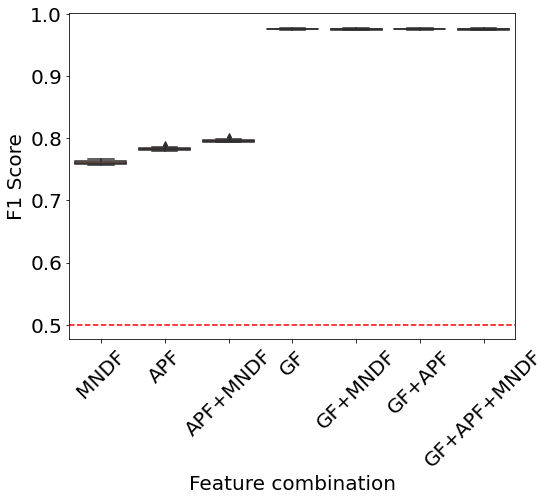

In [22]:
plt.rcParams.update({'figure.figsize' : (8,6)})
plt.rcParams.update({'font.size': 20})
ax = sns.boxplot(palette="flare", x="approach_name", y="f_score", data=filtered_results_df[(filtered_results_df.approach_name=='MNDF')|(filtered_results_df.approach_name=='APF')|(filtered_results_df.approach_name=='APF+MNDF')|(filtered_results_df.approach_name=='GF')|(filtered_results_df.approach_name=='GF+MNDF')|(filtered_results_df.approach_name=='GF+APF')|(filtered_results_df.approach_name=='GF+APF+MNDF')])
ax.set(xlabel='Feature combination', ylabel='F1 Score')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.axhline(0.5, ls='--', color='red')
plt.savefig('link-prediction-results_all.pdf', dpi=300, bbox_inches = "tight")

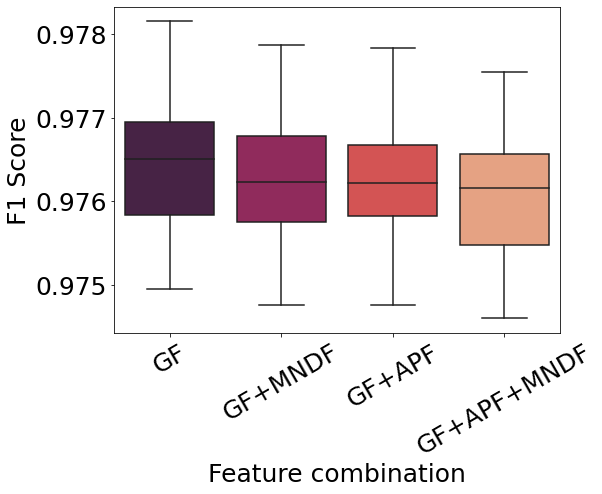

In [155]:
ax = sns.boxplot(palette="rocket", x="approach_name", y="f_score", data=filtered_results_df[(filtered_results_df.approach_name=='GF')|(filtered_results_df.approach_name=='GF+MNDF')|(filtered_results_df.approach_name=='GF+APF')|(filtered_results_df.approach_name=='GF+APF+MNDF')])
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set(xlabel='Feature combination', ylabel='F1 Score')
plt.savefig('link-prediction-results_network.pdf', dpi=300, bbox_inches = "tight")

In [107]:
feature_importances = []
for evaluation_result in evaluation_results_new:
    if evaluation_result['network_features']==False and evaluation_result['listening_profile_features']==True and evaluation_result['listening_characteristics_features']==True:
        tmp = {}
        for entry in evaluation_result['xgb_feature_importances']:
            tmp[entry[1]] = entry[0]
        feature_importances.append(tmp)

In [109]:
feature_importances_df = pd.DataFrame(feature_importances)

In [135]:
#pd.options.display.max_rows = 4000

# cosine similarity NMF artist profiles
nmf_cos = [0.0964]

# artist profile NMF features
nmf = [0.014467,0.013714,0.012132,0.012415,0.013930,0.012921,0.012641,0.012040,0.009208,0.011508,0.007551,0.010624,0.010258,0.011726,0.011659,0.010974,0.008955,0.011105,0.012269,0.011755,0.009841,0.012145,0.008594,0.010203,0.010201,0.010388,0.009355,0.008472,0.011826,0.009174,0.009399,0.007929,0.008068,0.008373,0.008737,0.008029,0.007460,0.009045,0.006984,0.006976]

# mainstreaminess features
mf = [0.012942,0.011272,0.010631,0.010595,0.008229,0.008650,0.008404,0.007011]
# relative change mainstreaminess features
mf_rc = [0.003321,0.003932,0.002448,0.002681]
# same user groups mainstreaminess
mf_sug = [0.001538,0.001997,0.002758,0.003744]
# user groups mainstreaminess
mf_ug = [0.005767,0.009106,0.004232,0.009033,0.009249,0.004761,0.008786,0.004975]

# novelty features
nf = [0.011938,0.012331,0.010170,0.008691,0.008472,0.008414]
# relative change novelty features
nf_rc = [0.004122,0.002660,0.002860]
# same user groups novelty
nf_sug = [0.004988,0.002474,0.001941]
# user groups novelty
nf_ug = [0.011275,0.006157,0.009254,0.008967,0.007628,0.005738]

# diversity features
df = [0.010663,0.010581,0.009270,0.010307,0.007928,0.007486,0.015052,0.010120,0.010731,0.008015]
# relative change diversity features
df_rc = [0.004825,0.003638,0.002786,0.003417,0.003322]
# same user groups diversity
df_sug = [0.005174, 0.004901,0.002172,0.001804,0.001618]
# user groups diversity
df_ug = [0.007160,0.010064,0.005247,0.006982,0.005752,0.008968,0.010700,0.006686,0.007070,0.004009]

In [145]:
# absolute contributions
# mndf
print(sum(mf+mf_rc+mf_sug+mf_ug+nf+nf_rc+nf_sug+nf_ug+df+df_rc+df_sug+df_ug))
# apf 
print(sum(nmf + nmf_cos))
# mf
print(sum(mf+mf_rc+mf_sug+mf_ug))
# nf
print(sum(nf+nf_rc+nf_sug+nf_ug))
# df
print(sum(df+df_rc+df_sug+df_ug))

# relative contributions
# mndf
print(sum(mf+mf_rc+mf_sug+mf_ug+nf+nf_rc+nf_sug+nf_ug+df+df_rc+df_sug+df_ug)/len(mf+mf_rc+mf_sug+mf_ug+nf+nf_rc+nf_sug+nf_ug+df+df_rc+df_sug+df_ug))
# apf
print(sum(nmf + nmf_cos)/len(nmf + nmf_cos))
# mf
print(sum(mf+mf_rc+mf_sug+mf_ug)/len(mf+mf_rc+mf_sug+mf_ug))
# nf
print(sum(nf+nf_rc+nf_sug+nf_ug)/len(nf+nf_rc+nf_sug+nf_ug))
# df
print(sum(df+df_rc+df_sug+df_ug)/len(df+df_rc+df_sug+df_ug))

0.4905900000000001
0.5094510000000001
0.15606199999999998
0.12808
0.206448
0.006813750000000001
0.012425634146341466
0.0065025833333333324
0.0071155555555555555
0.0068816


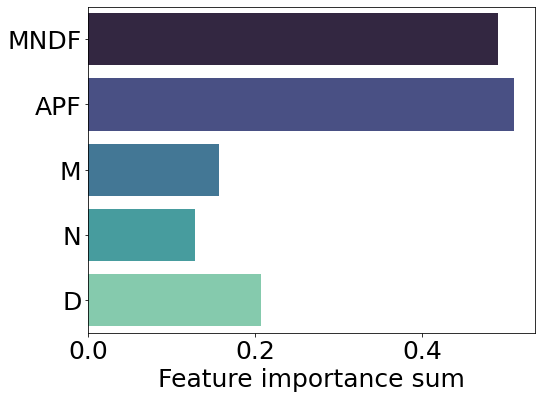

In [168]:
ax = sns.barplot(x=[0.4905900000000001, 0.5094510000000001, 0.15606199999999998, 0.12808, 0.206448], y=['MNDF', 'APF', 'M', 'N', 'D'], palette='mako')
ax.set(xlabel="Feature importance sum")
plt.savefig('feature-importance-sum.pdf', dpi=300, bbox_inches = "tight")

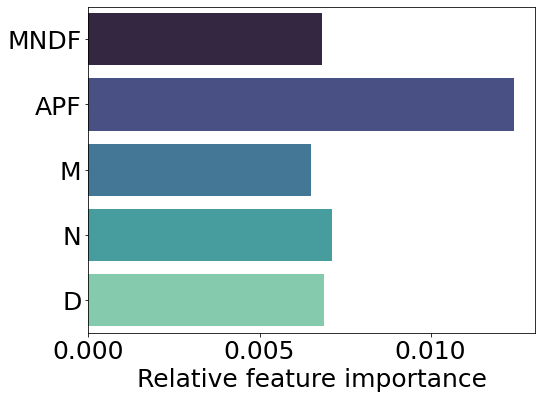

In [169]:
ax = sns.barplot(x=[0.006813750000000001, 0.012425634146341466, 0.0065025833333333324, 0.0071155555555555555, 0.0068816], y=['MNDF', 'APF', 'M', 'N', 'D'], palette='mako')
ax.set(xlabel="Relative feature importance")
plt.savefig('relative-feature-importance.pdf', dpi=300, bbox_inches = "tight")

In [ ]:
    listening_characteristics_features_df = listening_characteristics_features_df[['user1_user_id',
                                                                               'user2_user_id',
                                                                               'user1_mainstreaminess_global',
                                                                               'user1_user_groups_mainstreaminess_global_high',
                                                                               'user1_user_groups_mainstreaminess_global_low',
                                                                               'user1_user_groups_mainstreaminess_global_medium',
                                                                               'user2_mainstreaminess_global',
                                                                               'user2_user_groups_mainstreaminess_global_high',
                                                                               'user2_user_groups_mainstreaminess_global_low',
                                                                               'user2_user_groups_mainstreaminess_global_medium',
                                                                               'relative_change_mainstreaminess_global',
                                                                               'same_user_groups_mainstreaminess_global',
                                                                               'user1_novelty_artist_avg_6months',
                                                                               'user1_user_groups_novelty_artist_avg_6months_high',
                                                                               'user1_user_groups_novelty_artist_avg_6months_low',
                                                                               'user1_user_groups_novelty_artist_avg_6months_medium',
                                                                               'user2_novelty_artist_avg_6months',
                                                                               'user2_user_groups_novelty_artist_avg_6months_high',
                                                                               'user2_user_groups_novelty_artist_avg_6months_low',
                                                                               'user2_user_groups_novelty_artist_avg_6months_medium',
                                                                               'relative_change_novelty_artist_avg_6months',
                                                                               'same_user_groups_novelty_artist_avg_6months',
                                                                               'user1_freebase_weighted_average_diversity',
                                                                               'user1_user_groups_freebase_weighted_average_diversity_high',
                                                                               'user1_user_groups_freebase_weighted_average_diversity_low',
                                                                               'user1_user_groups_freebase_weighted_average_diversity_medium',
                                                                               'user2_freebase_weighted_average_diversity',
                                                                               'user2_user_groups_freebase_weighted_average_diversity_high',
                                                                               'user2_user_groups_freebase_weighted_average_diversity_low',
                                                                               'user2_user_groups_freebase_weighted_average_diversity_medium',
                                                                               'relative_change_freebase_weighted_average_diversity',
                                                                               'same_user_groups_freebase_weighted_average_diversity',
                                                                               'label']]

In [42]:
evaluation_results = []
for dataset_id in range(1):
    # Load datasets
    listening_profile_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_id) + '/links_df_listening_profile_features.csv', index_col=0)
    listening_profile_features_df = listening_profile_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)
    listening_characteristics_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_id) + '/links_df_listening_characteristics_features.csv', index_col=0)
    listening_characteristics_features_df = listening_characteristics_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True)

    # Map dataframes by attribute types
    feature_dict = {
        'lpf':listening_profile_features_df,
        'lcf':listening_characteristics_features_df
    }
    for split_seed in range(1):
        for lpf in [None, 'lpf']:
            for lcf in [None, 'lcf']:
                feature_combination = (lpf, lcf)
                print('Other features - dataset_id: ', dataset_id, ', split_seed: ', split_seed, ', feature_combination: ', feature_combination)
                log.info('Other features - dataset_id: ', dataset_id, ', split_seed: ', split_seed, ', feature_combination: ', feature_combination)
                if feature_combination == (None,None):
                    continue
                dfs_to_combine = []
                for x in (lpf, lcf):
                    if x is not None:
                        dfs_to_combine.append(feature_dict[x])
                input_df = pd.concat(dfs_to_combine, axis=1)
                input_df = input_df.loc[:,~input_df.columns.duplicated()]
                                
                X_train, X_test, y_train, y_test = train_test_split(input_df.drop(columns=['label']), input_df['label'], test_size=0.2, random_state=split_seed)
                xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
                user_ids_test = pd.DataFrame(X_test[['user1_user_id', 'user2_user_id']])
                X_train = X_train.drop(columns=['user1_user_id', 'user2_user_id'])
                X_test = X_test.drop(columns=['user1_user_id', 'user2_user_id'])
                xgb.fit(X_train, y_train)
                y_pred = xgb.predict(X_test)
                predictions = [round(value) for value in y_pred]
                # evaluate predictions
                report = classification_report(y_test, predictions)
                prfs_macro = precision_recall_fscore_support(y_test, predictions, average='macro')
                prfs_micro = precision_recall_fscore_support(y_test, predictions, average='micro')
                prfs_weighted = precision_recall_fscore_support(y_test, predictions, average='weighted')
                print(prfs_weighted)
                feature_importances = sorted(list(zip(xgb.feature_importances_, list(X_train.columns))),  key=lambda x: x[0], reverse=True)
                evaluation_result = {
                    'dataset_id': dataset_id,
                    'split_seed': split_seed,
                    'listening_profile_features': False if lpf is None else True,
                    'listening_characteristics_features': False if lcf is None else True,
                    'report': report,
                    'xgb_feature_importances': feature_importances,
                    'user_ids_test': user_ids_test,
                    'y_test': y_test,
                    'y_pred': y_pred,
                    'prfs_macro': prfs_macro,
                    'prfs_micro': prfs_micro,
                    'prfs_weighted': prfs_weighted
                }
                evaluation_results.append(evaluation_result)

Other features - dataset_id:  0 , split_seed:  0 , feature_combination:  (None, None)
Other features - dataset_id:  0 , split_seed:  0 , feature_combination:  (None, 'lcf')
[11:26:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7659966306300999, 0.7656665400683631, 0.7655750538873909, None)
Other features - dataset_id:  0 , split_seed:  0 , feature_combination:  ('lpf', None)
[11:27:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7836066930268092, 0.7835169008735283, 0.7834911350248384, None)
Other features - dataset_id:  0 , split_seed:  0 , feature_combination:  ('lpf', 'lcf')
[11:28:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/tduricic/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.7930589034285619, 0.7930117736422332, 0.7929975794569828, None)


In [43]:
# (None, 'lcf')
user_ids_test_df = pd.DataFrame(evaluation_results[0]['user_ids_test'])
user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[0]['y_test']]))
user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[0]['y_pred']]))
user_ids_test_df.columns = ['user1_user_id', 'user2_user_id', 'y_test', 'y_pred']
user_ids_test_df['hit'] = np.where(user_ids_test_df["y_test"] == user_ids_test_df["y_pred"], True, False)
user_ids_test_df = user_ids_test_df.merge(listening_characteristics_features_df, how='left', on=['user1_user_id', 'user2_user_id'])
high_novelty_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_novelty_artist_avg_6months_high==1)|(user_ids_test_df.user2_user_groups_novelty_artist_avg_6months_high==1)]
medium_novelty_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_novelty_artist_avg_6months_medium==1)|(user_ids_test_df.user2_user_groups_novelty_artist_avg_6months_medium==1)]
low_novelty_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_novelty_artist_avg_6months_low==1)|(user_ids_test_df.user2_user_groups_novelty_artist_avg_6months_low==1)]

high_diversity_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_freebase_weighted_average_diversity_high==1)|(user_ids_test_df.user2_user_groups_freebase_weighted_average_diversity_high==1)]
medium_diversity_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_freebase_weighted_average_diversity_medium==1)|(user_ids_test_df.user2_user_groups_freebase_weighted_average_diversity_medium==1)]
low_diversity_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_freebase_weighted_average_diversity_low==1)|(user_ids_test_df.user2_user_groups_freebase_weighted_average_diversity_low==1)]

high_mainstreaminess_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_mainstreaminess_global_high==1)|(user_ids_test_df.user2_user_groups_mainstreaminess_global_high==1)]
medium_mainstreaminess_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_mainstreaminess_global_medium==1)|(user_ids_test_df.user2_user_groups_mainstreaminess_global_medium==1)]
low_mainstreaminess_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_mainstreaminess_global_low==1)|(user_ids_test_df.user2_user_groups_mainstreaminess_global_low==1)]

print('Using only mainstreaminess, novelty and diversity:')
print('High novelty:', len(high_novelty_df[high_novelty_df.hit==True])/len(high_novelty_df))
print('Medium novelty:', len(medium_novelty_df[medium_novelty_df.hit==True])/len(medium_novelty_df))
print('Low novelty:', len(low_novelty_df[low_novelty_df.hit==True])/len(low_novelty_df))

print('High diversity:', len(high_diversity_df[high_diversity_df.hit==True])/len(high_diversity_df))
print('Medium diversity:', len(medium_diversity_df[medium_diversity_df.hit==True])/len(medium_diversity_df))
print('Low diversity:', len(low_diversity_df[low_diversity_df.hit==True])/len(low_diversity_df))

print('High mainstreaminess:', len(high_mainstreaminess_df[high_mainstreaminess_df.hit==True])/len(high_mainstreaminess_df))
print('Medium mainstreaminess:', len(medium_mainstreaminess_df[medium_mainstreaminess_df.hit==True])/len(medium_mainstreaminess_df))
print('Low mainstreaminess:', len(low_mainstreaminess_df[low_mainstreaminess_df.hit==True])/len(low_mainstreaminess_df))

<ipython-input-43-ed87d8205faa>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[0]['y_test']]))
<ipython-input-43-ed87d8205faa>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[0]['y_pred']]))


Using only mainstreaminess, novelty and diversity:
High novelty: 0.7811454249928291
Medium novelty: 0.7643693453964875
Low novelty: 0.7655225764423272
High diversity: 0.7709854014598541
Medium diversity: 0.769082306064002
Low diversity: 0.7671633477231583
High mainstreaminess: 0.7761336930977457
Medium mainstreaminess: 0.7602422979222302
Low mainstreaminess: 0.7668794656068998


In [44]:
# ('lpf', None)
print('Using only artist profiles:')
user_ids_test_df = pd.DataFrame(evaluation_results[1]['user_ids_test'])
user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[1]['y_test']]))
user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[1]['y_pred']]))
user_ids_test_df.columns = ['user1_user_id', 'user2_user_id', 'y_test', 'y_pred']
user_ids_test_df['hit'] = np.where(user_ids_test_df["y_test"] == user_ids_test_df["y_pred"], True, False)
user_ids_test_df = user_ids_test_df.merge(listening_characteristics_features_df, how='left', on=['user1_user_id', 'user2_user_id'])
high_novelty_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_novelty_artist_avg_6months_high==1)|(user_ids_test_df.user2_user_groups_novelty_artist_avg_6months_high==1)]
medium_novelty_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_novelty_artist_avg_6months_medium==1)|(user_ids_test_df.user2_user_groups_novelty_artist_avg_6months_medium==1)]
low_novelty_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_novelty_artist_avg_6months_low==1)|(user_ids_test_df.user2_user_groups_novelty_artist_avg_6months_low==1)]

high_diversity_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_freebase_weighted_average_diversity_high==1)|(user_ids_test_df.user2_user_groups_freebase_weighted_average_diversity_high==1)]
medium_diversity_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_freebase_weighted_average_diversity_medium==1)|(user_ids_test_df.user2_user_groups_freebase_weighted_average_diversity_medium==1)]
low_diversity_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_freebase_weighted_average_diversity_low==1)|(user_ids_test_df.user2_user_groups_freebase_weighted_average_diversity_low==1)]

high_mainstreaminess_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_mainstreaminess_global_high==1)|(user_ids_test_df.user2_user_groups_mainstreaminess_global_high==1)]
medium_mainstreaminess_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_mainstreaminess_global_medium==1)|(user_ids_test_df.user2_user_groups_mainstreaminess_global_medium==1)]
low_mainstreaminess_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_mainstreaminess_global_low==1)|(user_ids_test_df.user2_user_groups_mainstreaminess_global_low==1)]

print('High novelty:', len(high_novelty_df[high_novelty_df.hit==True])/len(high_novelty_df))
print('Medium novelty:', len(medium_novelty_df[medium_novelty_df.hit==True])/len(medium_novelty_df))
print('Low novelty:', len(low_novelty_df[low_novelty_df.hit==True])/len(low_novelty_df))

print('High diversity:', len(high_diversity_df[high_diversity_df.hit==True])/len(high_diversity_df))
print('Medium diversity:', len(medium_diversity_df[medium_diversity_df.hit==True])/len(medium_diversity_df))
print('Low diversity:', len(low_diversity_df[low_diversity_df.hit==True])/len(low_diversity_df))

print('High mainstreaminess:', len(high_mainstreaminess_df[high_mainstreaminess_df.hit==True])/len(high_mainstreaminess_df))
print('Medium mainstreaminess:', len(medium_mainstreaminess_df[medium_mainstreaminess_df.hit==True])/len(medium_mainstreaminess_df))
print('Low mainstreaminess:', len(low_mainstreaminess_df[low_mainstreaminess_df.hit==True])/len(low_mainstreaminess_df))

Using only artist profiles:


<ipython-input-44-445130328e1f>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[1]['y_test']]))
<ipython-input-44-445130328e1f>:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[1]['y_pred']]))


High novelty: 0.7958695860024859
Medium novelty: 0.7815992549228313
Low novelty: 0.7811571190098123
High diversity: 0.7829227493917275
Medium diversity: 0.787822189017557
Low diversity: 0.7817388478856241
High mainstreaminess: 0.794673165636696
Medium mainstreaminess: 0.7818016022927116
Low mainstreaminess: 0.7813807973618568


In [45]:
# ('lpf', 'lcf')
user_ids_test_df = pd.DataFrame(evaluation_results[2]['user_ids_test'])
user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[2]['y_test']]))
user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[2]['y_pred']]))
user_ids_test_df.columns = ['user1_user_id', 'user2_user_id', 'y_test', 'y_pred']
user_ids_test_df['hit'] = np.where(user_ids_test_df["y_test"] == user_ids_test_df["y_pred"], True, False)
user_ids_test_df = user_ids_test_df.merge(listening_characteristics_features_df, how='left', on=['user1_user_id', 'user2_user_id'])
high_novelty_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_novelty_artist_avg_6months_high==1)|(user_ids_test_df.user2_user_groups_novelty_artist_avg_6months_high==1)]
medium_novelty_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_novelty_artist_avg_6months_medium==1)|(user_ids_test_df.user2_user_groups_novelty_artist_avg_6months_medium==1)]
low_novelty_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_novelty_artist_avg_6months_low==1)|(user_ids_test_df.user2_user_groups_novelty_artist_avg_6months_low==1)]

high_diversity_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_freebase_weighted_average_diversity_high==1)|(user_ids_test_df.user2_user_groups_freebase_weighted_average_diversity_high==1)]
medium_diversity_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_freebase_weighted_average_diversity_medium==1)|(user_ids_test_df.user2_user_groups_freebase_weighted_average_diversity_medium==1)]
low_diversity_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_freebase_weighted_average_diversity_low==1)|(user_ids_test_df.user2_user_groups_freebase_weighted_average_diversity_low==1)]

high_mainstreaminess_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_mainstreaminess_global_high==1)|(user_ids_test_df.user2_user_groups_mainstreaminess_global_high==1)]
medium_mainstreaminess_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_mainstreaminess_global_medium==1)|(user_ids_test_df.user2_user_groups_mainstreaminess_global_medium==1)]
low_mainstreaminess_df = user_ids_test_df[(user_ids_test_df.user1_user_groups_mainstreaminess_global_low==1)|(user_ids_test_df.user2_user_groups_mainstreaminess_global_low==1)]

print('Using both:')
print('High novelty:', len(high_novelty_df[high_novelty_df.hit==True])/len(high_novelty_df))
print('Medium novelty:', len(medium_novelty_df[medium_novelty_df.hit==True])/len(medium_novelty_df))
print('Low novelty:', len(low_novelty_df[low_novelty_df.hit==True])/len(low_novelty_df))

print('High diversity:', len(high_diversity_df[high_diversity_df.hit==True])/len(high_diversity_df))
print('Medium diversity:', len(medium_diversity_df[medium_diversity_df.hit==True])/len(medium_diversity_df))
print('Low diversity:', len(low_diversity_df[low_diversity_df.hit==True])/len(low_diversity_df))

print('High mainstreaminess:', len(high_mainstreaminess_df[high_mainstreaminess_df.hit==True])/len(high_mainstreaminess_df))
print('Medium mainstreaminess:', len(medium_mainstreaminess_df[medium_mainstreaminess_df.hit==True])/len(medium_mainstreaminess_df))
print('Low mainstreaminess:', len(low_mainstreaminess_df[low_mainstreaminess_df.hit==True])/len(low_mainstreaminess_df))

<ipython-input-45-72e32c841bc9>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[2]['y_test']]))
<ipython-input-45-72e32c841bc9>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  user_ids_test_df = pd.DataFrame(pd.np.column_stack([user_ids_test_df, evaluation_results[2]['y_pred']]))


Using both:
High novelty: 0.7971125346591452
Medium novelty: 0.7872538584353379
Low novelty: 0.7953259232115956
High diversity: 0.7924270072992701
Medium diversity: 0.7908728676379031
Low diversity: 0.7971498862739637
High mainstreaminess: 0.7908434154408565
Medium mainstreaminess: 0.7859701686966717
Low mainstreaminess: 0.7974886906523485


In [22]:
listening_characteristics_features_df = listening_characteristics_features_df[['user1_user_id',
                                                                               'user2_user_id',
                                                                               'user1_mainstreaminess_global',
                                                                               'user1_user_groups_mainstreaminess_global_high',
                                                                               'user1_user_groups_mainstreaminess_global_low',
                                                                               'user1_user_groups_mainstreaminess_global_medium',
                                                                               'user2_mainstreaminess_global',
                                                                               'user2_user_groups_mainstreaminess_global_high',
                                                                               'user2_user_groups_mainstreaminess_global_low',
                                                                               'user2_user_groups_mainstreaminess_global_medium',
                                                                               'relative_change_mainstreaminess_global',
                                                                               'same_user_groups_mainstreaminess_global',
                                                                               'user1_novelty_artist_avg_6months',
                                                                               'user1_user_groups_novelty_artist_avg_6months_high',
                                                                               'user1_user_groups_novelty_artist_avg_6months_low',
                                                                               'user1_user_groups_novelty_artist_avg_6months_medium',
                                                                               'user2_novelty_artist_avg_6months',
                                                                               'user2_user_groups_novelty_artist_avg_6months_high',
                                                                               'user2_user_groups_novelty_artist_avg_6months_low',
                                                                               'user2_user_groups_novelty_artist_avg_6months_medium',
                                                                               'relative_change_novelty_artist_avg_6months',
                                                                               'same_user_groups_novelty_artist_avg_6months',
                                                                               'user1_freebase_weighted_average_diversity',
                                                                               'user1_user_groups_freebase_weighted_average_diversity_high',
                                                                               'user1_user_groups_freebase_weighted_average_diversity_low',
                                                                               'user1_user_groups_freebase_weighted_average_diversity_medium',
                                                                               'user2_freebase_weighted_average_diversity',
                                                                               'user2_user_groups_freebase_weighted_average_diversity_high',
                                                                               'user2_user_groups_freebase_weighted_average_diversity_low',
                                                                               'user2_user_groups_freebase_weighted_average_diversity_medium',
                                                                               'relative_change_freebase_weighted_average_diversity',
                                                                               'same_user_groups_freebase_weighted_average_diversity']]

user1_user_id
user2_user_id
user1_mainstreaminess_avg_month
user1_mainstreaminess_avg_6months
user1_mainstreaminess_avg_year
user1_mainstreaminess_global
user1_user_groups_mainstreaminess_avg_month_high
user1_user_groups_mainstreaminess_avg_month_low
user1_user_groups_mainstreaminess_avg_month_medium
user1_user_groups_mainstreaminess_avg_6months_high
user1_user_groups_mainstreaminess_avg_6months_low
user1_user_groups_mainstreaminess_avg_6months_medium
user1_user_groups_mainstreaminess_avg_year_high
user1_user_groups_mainstreaminess_avg_year_low
user1_user_groups_mainstreaminess_avg_year_medium
user1_user_groups_mainstreaminess_global_high
user1_user_groups_mainstreaminess_global_low
user1_user_groups_mainstreaminess_global_medium
user2_mainstreaminess_avg_month
user2_mainstreaminess_avg_6months
user2_mainstreaminess_avg_year
user2_mainstreaminess_global
user2_user_groups_mainstreaminess_avg_month_high
user2_user_groups_mainstreaminess_avg_month_low
user2_user_groups_mainstreaminess_avg

In [19]:
user_ids_test_df

,user1_user_id,user2_user_id,y_test,y_pred
0,19013343,39600166,0,0
1,14155395,2508412,0,0
2,8882206,18569602,1,1
3,30142311,48966945,0,0
4,39854779,1047533,1,1
...,...,...,...,...
31591,40698923,6547853,0,0
31592,35203241,5093623,1,1
31593,5278741,16427212,1,1
31594,12814574,8396864,1,0


In [14]:
evaluation_results[2]['listening_characteristics_features']

True

In [179]:
genre_features_df.columns

Index(['user1_user_id', 'user2_user_id', 'user1_allmusic_rnb',
       'user1_allmusic_rap', 'user1_allmusic_electronic',
       'user1_allmusic_rock', 'user1_allmusic_new age',
       'user1_allmusic_classical', 'user1_allmusic_reggae',
       'user1_allmusic_blues', 'user1_allmusic_country',
       'user1_allmusic_world', 'user1_allmusic_folk',
       'user1_allmusic_easy listening', 'user1_allmusic_jazz',
       'user1_allmusic_vocal', 'user1_allmusic_children's',
       'user1_allmusic_punk', 'user1_allmusic_alternative',
       'user1_allmusic_spoken word', 'user1_allmusic_pop',
       'user1_allmusic_heavy metal', 'user2_allmusic_rnb',
       'user2_allmusic_rap', 'user2_allmusic_electronic',
       'user2_allmusic_rock', 'user2_allmusic_new age',
       'user2_allmusic_classical', 'user2_allmusic_reggae',
       'user2_allmusic_blues', 'user2_allmusic_country',
       'user2_allmusic_world', 'user2_allmusic_folk',
       'user2_allmusic_easy listening', 'user2_allmusic_jazz',
   

In [ ]:
def calculate_jaccard_coefficient(df, G):
    df['jaccard_coefficient'] = df.apply(lambda x: get_jaccard_coefficient(G, x['user1_user_id'], x['user2_user_id']), axis=1)
    return df

def calculate_adamic_adar_coefficient(df, G):
    df['adamic_adar_coefficient'] = df.apply(lambda x: get_adamic_adar_index(G, x['user1_user_id'], x['user2_user_id']), axis=1)
    return df

def calculate_common_neighbors(df, G):
    df['common_neighbors'] = df.apply(lambda x: get_common_neighbors(G, x['user1_user_id'], x['user2_user_id']), axis=1)
    return df

def get_jaccard_coefficient(G, user1, user2):
    return list(nx.jaccard_coefficient(G, [(user1, user2)]))[0][2]

def get_adamic_adar_index(G, user1, user2):
    return list(nx.adamic_adar_index(G, [(user1, user2)]))[0][2]

def get_common_neighbors(G, user1, user2):
    return len(list(nx.common_neighbors(G, user1, user2)))

network_df_evaluation_results = []
for dataset_id in range(10):
    for split_seed in range(5):
        print('Network features - dataset_id:', dataset_id, ', split_seed:', split_seed)
        log.info('Network features - dataset_id:', dataset_id, ', split_seed:', split_seed)
        # Load datasets
        network_features_df = pd.read_csv('dataframes/links_dfs/' + str(dataset_index) + '/links_df_network_features.csv', index_col=0)
        network_features_df = network_features_df.sample(random_state=dataset_id, frac=1).reset_index(drop=True).drop(columns=['jaccard_coefficient', 'adamic_adar_coefficient', 'common_neighbors'])
        X_train, X_test, y_train, y_test = train_test_split(network_features_df.drop(columns='label'), network_features_df['label'], test_size=0.2, random_state=split_seed)
        user_ids_test = pd.DataFrame(X_test[['user1_user_id', 'user2_user_id']])
        # Use only edges in X_train
        edges = list(zip(X_train['user1_user_id'].values, X_train['user2_user_id'].values))
        G = nx.Graph()
        for edge in edges:
            G.add_edge(edge[0], edge[1])
        X_train = calculate_jaccard_coefficient(X_train, G)
        X_train = calculate_adamic_adar_coefficient(X_train, G)
        X_train = calculate_common_neighbors(X_train, G).drop(columns=['user1_user_id', 'user2_user_id'])
        X_test = calculate_jaccard_coefficient(X_test, G)
        X_test = calculate_adamic_adar_coefficient(X_test, G)
        X_test = calculate_common_neighbors(X_test, G).drop(columns=['user1_user_id', 'user2_user_id'])
        xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        predictions = [round(value) for value in y_pred]
        # evaluate predictions
        report = classification_report(y_test, predictions)
        prfs_macro = precision_recall_fscore_support(y_test, predictions, average='macro')
        prfs_micro = precision_recall_fscore_support(y_test, predictions, average='micro')
        prfs_weighted = precision_recall_fscore_support(y_test, predictions, average='weighted')
        feature_importances = sorted(list(zip(xgb.feature_importances_, list(X_train.columns))),  key=lambda x: x[0], reverse=True)
        network_df_evaluation_result = {
            'dataset_id': dataset_id,
            'split_seed': split_seed,
            'report': report,
            'xgb_feature_importances': feature_importances,
            'user_ids_test': X_test,
            'y_test': y_test,
            'y_pred': y_pred,
            'prfs_macro': prfs_macro,
            'prfs_micro': prfs_micro,
            'prfs_weighted': prfs_weighted
        }
        network_df_evaluation_results.append(network_df_evaluation_result)

In [180]:
# network_df_evaluation_results
lala = []
for evaluation_result in evaluation_results:
    lala.append({
        'demographic_features':evaluation_result['demographic_features'],
        'listening_profile_features':evaluation_result['listening_profile_features'],
        'genre_features':evaluation_result['genre_features'],
        'listening_characteristics_features':evaluation_result['listening_characteristics_features'],
        'dataset_id':evaluation_result['dataset_id'],
        'split_seed':evaluation_result['split_seed'],
        'precision':evaluation_result['prfs_weighted'][0],
        'recall':evaluation_result['prfs_weighted'][1],
        'f1':evaluation_result['prfs_weighted'][2],
        'xgb_feature_importances':evaluation_result['xgb_feature_importances']
    })

In [186]:
lala_df = pd.DataFrame(lala)

In [188]:
lala_df[(lala_df.demographic_features==False)&(lala.listening_profile_features==False)&(lala.genre_features==False)&(lala.listening_characteristics_features==True)]

AttributeError: 'list' object has no attribute 'listening_profile_features'

In [177]:
lala_df.groupby(['demographic_features', 'listening_profile_features', 'genre_features', 'listening_characteristics_features']).mean()

dataset_id  \
demographic_features listening_profile_features genre_features listening_characteristics_features               
False                False                      False          True                                       4.5   
                                                True           False                                      4.5   
                                                               True                                       4.5   
                     True                       False          False                                      4.5   
                                                               True                                       4.5   
                                                True           False                                      4.5   
                                                               True                                       4.5   
True                 False                      False          False                                      4.5   
                                                               True                                       4.5   
                                                True           False                                      4.5   
                                                               True                                       4.5   
                     True                       False          False                                      4.5   
                                                               True                                       4.5   
                                                True           False                                      4.5   
                                                               True                                       4.5   

                                                                                                   split_seed  \
demographic_features listening_profile_features genre_features listening_characteristics_features               
False                False                      False          True                                       2.0   
                                                True           False                                      2.0   
                                                               True                                       2.0   
                     True                       False          False                                      2.0   
                                                               True                                       2.0   
                                                True           False                                      2.0   
                                                               True                                       2.0   
True                 False                      False          False                                      2.0   
                                                               True                                       2.0   
                                                True           False                                      2.0   
                                                               True                                       2.0   
                     True                       False          False                                      2.0   
                                                               True                                       2.0   
                                                True           False                                      2.0   
                                                               True                                       2.0   

                                                                                                   precision  \
demographic_features listening_profile_features genre_features listening_characteristics_features              
False                False     

In [119]:
X_train, X_test, y_train, y_test = train_test_split(demographic_features_df.drop(columns='label'), demographic_features_df['label'], test_size=0.25, random_state=12, shuffle=True)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb.fit(X_train, y_train)
feature_importances['demographic_features_df'] = xgb.feature_importances_
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
report = classification_report(np.array(y_test), np.array(predictions))
#confusion_matrix = confusion_matrix(np.array(y_test), np.array(predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(report)
#print(confusion_matrix)

[18:18:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 70.19%
              precision    recall  f1-score   support

           0       0.68      0.74      0.71     19679
           1       0.72      0.66      0.69     19816

    accuracy                           0.70     39495
   macro avg       0.70      0.70      0.70     39495
weighted avg       0.70      0.70      0.70     39495



In [120]:
X_test

,user1_user_id,user2_user_id,user1_gender_f,user1_gender_m,user1_gender_n,user2_gender_f,user2_gender_m,user2_gender_n,same_gender,user1_age,...,user2_country_VG,user2_country_VI,user2_country_VN,user2_country_VU,user2_country_WF,user2_country_WS,user2_country_ZA,user2_country_ZM,user2_country_ZW,same_country
104371,5940367,24186212,0,1,0,0,1,0,1,21,...,0,0,0,0,0,0,0,0,0,0
119109,14442449,30596786,1,0,0,0,1,0,0,24,...,0,0,0,0,0,0,0,0,0,0
8655,8514109,7714668,0,1,0,1,0,0,0,23,...,0,0,0,0,0,0,0,0,0,0
4541,31658433,30569777,0,1,0,0,1,0,1,-1,...,0,0,0,0,0,0,0,0,0,0
44719,27837434,39785132,0,0,1,1,0,0,0,19,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110969,8800774,22253813,1,0,0,0,0,1,0,21,...,0,0,0,0,0,0,0,0,0,0
125455,8275667,40212905,0,1,0,1,0,0,0,25,...,0,0,0,0,0,0,0,0,0,1
3828,8611860,49136186,0,1,0,0,0,1,0,22,...,0,0,0,0,0,0,0,0,0,0
115410,40973308,4983274,0,1,0,0,0,1,0,18,...,0,0,0,0,0,0,0,0,0,0


In [63]:
X_train, X_test, y_train, y_test = train_test_split(genre_features_df.drop(columns='label'), genre_features_df['label'], test_size=0.25, random_state=12)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb.fit(X_train, y_train)
xgb.feature_importances_
feature_importances['genre_features_df'] = xgb.feature_importances_
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
report = classification_report(np.array(y_test), np.array(predictions), target_names=['0','1'])
#confusion_matrix = confusion_matrix(np.array(y_test), np.array(predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(report)
#print(confusion_matrix)

[00:54:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 80.94%
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     19673
           1       0.82      0.80      0.81     19822

    accuracy                           0.81     39495
   macro avg       0.81      0.81      0.81     39495
weighted avg       0.81      0.81      0.81     39495



In [64]:
X_train, X_test, y_train, y_test = train_test_split(listening_profile_features_df.drop(columns='label'), listening_profile_features_df['label'], test_size=0.25, random_state=12)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb.fit(X_train, y_train)
xgb.feature_importances_
feature_importances['listening_profile_features_df'] = xgb.feature_importances_
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
report = classification_report(np.array(y_test), np.array(predictions), target_names=['0','1'])
#confusion_matrix = confusion_matrix(np.array(y_test), np.array(predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(report)
#print(confusion_matrix)

[00:54:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 78.18%
              precision    recall  f1-score   support

           0       0.77      0.80      0.78     19673
           1       0.79      0.77      0.78     19822

    accuracy                           0.78     39495
   macro avg       0.78      0.78      0.78     39495
weighted avg       0.78      0.78      0.78     39495



In [65]:
X_train, X_test, y_train, y_test = train_test_split(listening_characteristics_features_df.drop(columns='label'), listening_characteristics_features_df['label'], test_size=0.25, random_state=12)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb.fit(X_train, y_train)
xgb.feature_importances_
feature_importances['listening_characteristics_features_df'] = xgb.feature_importances_
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
report = classification_report(np.array(y_test), np.array(predictions), target_names=['0','1'])
#confusion_matrix = confusion_matrix(np.array(y_test), np.array(predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(report)
#print(confusion_matrix)

[00:54:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 76.35%
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     19673
           1       0.78      0.74      0.76     19822

    accuracy                           0.76     39495
   macro avg       0.76      0.76      0.76     39495
weighted avg       0.76      0.76      0.76     39495



In [66]:
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(columns='label'), full_df['label'], test_size=0.25, random_state=12)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb.fit(X_train, y_train)
xgb.feature_importances_
feature_importances['full_df'] = xgb.feature_importances_
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
report = classification_report(np.array(y_test), np.array(predictions), target_names=['0','1'])
#confusion_matrix = confusion_matrix(np.array(y_test), np.array(predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(report)
#print(confusion_matrix)

[00:55:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 97.64%
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     19673
           1       0.99      0.96      0.98     19822

    accuracy                           0.98     39495
   macro avg       0.98      0.98      0.98     39495
weighted avg       0.98      0.98      0.98     39495



In [67]:
full_df = full_df.drop(columns=['jaccard_coefficient','adamic_adar_coefficient','common_neighbors'])
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(columns='label'), full_df['label'], test_size=0.25, random_state=12)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb.fit(X_train, y_train)
xgb.feature_importances_
feature_importances['full_df'] = xgb.feature_importances_
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
report = classification_report(np.array(y_test), np.array(predictions), target_names=['0','1'])
#confusion_matrix = confusion_matrix(np.array(y_test), np.array(predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(report)
#print(confusion_matrix)

[00:55:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 83.45%
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     19673
           1       0.84      0.83      0.83     19822

    accuracy                           0.83     39495
   macro avg       0.83      0.83      0.83     39495
weighted avg       0.83      0.83      0.83     39495



In [142]:
sorted(list(zip(feature_importances['full_df'], list(full_df.columns))),  key=lambda x: x[0], reverse=True)

KeyError: 'full_df'

In [73]:
listening_characteristics_features_df.columns

Index(['user1_user_id', 'user2_user_id', 'user1_mainstreaminess_avg_month',
       'user1_mainstreaminess_avg_6months', 'user1_mainstreaminess_avg_year',
       'user1_mainstreaminess_global',
       'user1_user_groups_mainstreaminess_avg_month_high',
       'user1_user_groups_mainstreaminess_avg_month_low',
       'user1_user_groups_mainstreaminess_avg_month_medium',
       'user1_user_groups_mainstreaminess_avg_6months_high',
       ...
       'user1_user_groups_playcount_lognorm_high',
       'user1_user_groups_playcount_lognorm_low',
       'user1_user_groups_playcount_lognorm_medium', 'user2_playcount_lognorm',
       'user2_user_groups_playcount_lognorm_high',
       'user2_user_groups_playcount_lognorm_low',
       'user2_user_groups_playcount_lognorm_medium',
       'relative_change_playcount_lognorm',
       'same_user_groups_playcount_lognorm', 'label'],
      dtype='object', length=181)

In [ ]:
# for feature_combination in feature_combinations:
#     if feature_combination == (None,None,None,None):
#         continue
#     # split data into X and y
#     X = feature_combinations[feature_combination]['dataframe'].drop(columns=['user1_user_id','user2_user_id','label'])
#     Y = feature_combinations[feature_combination]['dataframe']['label']
#     # CV model
#     model = XGBClassifier(use_label_encoder=False)
#     kfold = StratifiedKFold(n_splits=10, random_state=7)
#     accuracy = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
#     precision = cross_val_score(model, X, Y, cv=kfold, scoring='precision')
#     recall = cross_val_score(model, X, Y, cv=kfold, scoring='recall')
#     f1 = cross_val_score(model, X, Y, cv=kfold, scoring='f1')
# #     support = cross_val_score(model, X, Y, cv=kfold, scoring='support')
#     feature_combinations[feature_combination]['accuracy'] = (accuracy.mean(), accuracy.std())
#     feature_combinations[feature_combination]['precision'] = (precision.mean(), precision.std())
#     feature_combinations[feature_combination]['recall'] = (recall.mean(), recall.std())
#     feature_combinations[feature_combination]['f1'] = (f1.mean(), f1.std())
# #     feature_combinations[feature_combination]['support'] = (support.mean(), support.std())